# BookCrossing Implicit Analysis

## Setup

In [1]:
library(gtable)
library(grid)
library(foreach)
library(reshape2)
library(tidyverse)
library(rstan)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
accumulate(): purrr, foreach
filter():     dplyr, stats
lag():        dplyr, stats
when():       purrr, foreach
Loading required package: StanHeaders
rstan (Version 2.16.2, packaged: 2017-07-03 09:24:58 UTC, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())

Attaching package: ‘rstan’

The following object is masked from ‘package:tidyr’:

    extract



In [2]:
library(doParallel)
registerDoParallel()
options(mc.cores=parallel::detectCores())

Loading required package: iterators
Loading required package: parallel


In [3]:
options(repr.matrix.max.rows=20)

In [4]:
source("../utils.R")

In [56]:
source_notebook("BiasModel.ipynb")

loading notebook with 21 cells
compiling independent Bayesian model
compiling independent Bayesian model with logit-normal
hash mismatch so recompiling; make sure Stan code ends with a blank line


In file included from /home/MICHAELEKSTRAND/miniconda2/envs/bias/lib/R/library/rstan/include/rstan/rstaninc.hpp:3:0,
                 from file4525264e530.cpp:575:
/home/MICHAELEKSTRAND/miniconda2/envs/bias/lib/R/library/rstan/include/rstan/stan_fit.hpp: In function 'int rstan::{anonymous}::command(rstan::stan_args&, Model&, Rcpp::List&, const std::vector<long unsigned int>&, const std::vector<std::__cxx11::basic_string<char> >&, RNG_t&)':
/home/MICHAELEKSTRAND/miniconda2/envs/bias/lib/R/library/rstan/include/rstan/stan_fit.hpp:438:8: warning: 'template<class> class std::auto_ptr' is deprecated [-Wdeprecated-declarations]
   std::auto_ptr<stan::io::var_context> init_context_ptr;
        ^~~~~~~~
In file included from /home/MICHAELEKSTRAND/miniconda2/envs/bias/x86_64-conda_cos6-linux-gnu/include/c++/7.2.0/bits/locale_conv.h:41:0,
                 from /home/MICHAELEKSTRAND/miniconda2/envs/bias/x86_64-conda_cos6-linux-gnu/include/c++/7.2.0/locale:43,
                 from /home/MICHAELEK

compiling full Bayesian model


Read input data

In [6]:
ratings = read_csv("../build/sample-ratings-implicit.csv")
item = read_csv("../build/bx-author-gender.csv")
recs = read_csv("../build/eval-recommendation-implicit.csv")
bx_implicit = read_csv("../build/bx-implicit.csv")

Parsed with column specification:
cols(
  userID = col_integer(),
  bookID = col_integer(),
  rating = col_integer()
)
Parsed with column specification:
cols(
  bookID = col_integer(),
  authorName = col_character(),
  authorGender = col_character()
)
Parsed with column specification:
cols(
  DataSet = col_character(),
  Algorithm = col_character(),
  User = col_integer(),
  Rank = col_integer(),
  Item = col_integer(),
  Score = col_double()
)
Parsed with column specification:
cols(
  userID = col_integer(),
  bookID = col_integer(),
  rating = col_integer()
)


In [7]:
item.authorID = read_csv("../build/bx-authorID-gender.csv")

Parsed with column specification:
cols(
  bookID = col_integer(),
  authorID = col_integer(),
  authorName = col_character(),
  authorGender = col_character()
)


In [8]:
nrow(item)

[1] 3369309

In [9]:
summary(as.factor(item$authorGender))

ambiguous    female      male   unknown 
    34034    569822   1614588   1150865

### Stats

**All bx implicit ratings**

Total number of implicit ratings

In [10]:
bx_implicit %>%
    distinct() %>%
    nrow()

[1] 1144995

Ratings of books with known-gender

In [11]:
bx_implicit %>%
    distinct() %>%
    inner_join(item) %>%
    filter(authorGender == 'male' | authorGender == 'female') %>%
    nrow()

Joining, by = "bookID"


[1] 840704

Total number of users

In [12]:
bx_implicit %>%
    select(userID) %>%
    distinct() %>%
    nrow()

[1] 105283

Books read by users

In [13]:
bx_implicit %>%
    select(bookID) %>%
    distinct() %>%
    nrow()

[1] 303876

Books matched with `bx-author-gender`

`bx-author-gender` results from inner_join between `book_first_author` and `author_resolution`

In [14]:
bx_implicit %>%
    select(bookID) %>%
    distinct() %>%
    inner_join(item) %>%
    nrow()

Joining, by = "bookID"


[1] 232548

Distinct authors among matched books

In [15]:
bx_implicit %>%
    select(bookID) %>%
    distinct() %>%
    inner_join(item.authorID %>% select(bookID, authorID)) %>%
    select(authorID) %>%
    distinct() %>%
    nrow()

Joining, by = "bookID"


[1] 98854

Known-Gender Books

In [16]:
bx_implicit %>%
    select(bookID) %>%
    distinct() %>%
    inner_join(item) %>%
    filter(authorGender == 'male' | authorGender == 'female') %>%
    nrow()

Joining, by = "bookID"


[1] 166742

## Sampled data stats

## Top Items

In [17]:
item.stats = ratings %>%
    group_by(bookID) %>%
    summarize(count=n()) %>%
    arrange(-count)
head(item.stats, n=10)

bookID,count
27430138,81
5199457,54
5131261,39
20773255,34
6348739,32
30519934,32
2201182,30
11316979,30
30082882,29
10236256,27


In [18]:
item.stats %>%
    inner_join(item) %>%
    head(n=10)

Joining, by = "bookID"


bookID,count,authorName,authorGender
27430138,81,Rich Shapero,male
5199457,54,Alice Sebold,female
5131261,39,Anne Rice,female
20773255,34,Dan Brown,male
6348739,32,J. K. Rowling,female
30519934,32,John Grisham,male
2201182,30,Melissa Bank,female
11316979,30,Dena Neusner,female
30082882,29,Sue Monk Kidd,female
10236256,27,Michael Crichton,male


In [19]:
item.stats %>% 
    inner_join(item) %>%
    arrange(-count) %>% 
    head(n=50) %>%
    select(count, authorGender) %>%
    summary()

Joining, by = "bookID"


     count    authorGender      
 Min.   :18   Length:50         
 1st Qu.:20   Class :character  
 Median :22   Mode  :character  
 Mean   :25                     
 3rd Qu.:25                     
 Max.   :81                     

## Summarize and Integrate

In [20]:
user.rating_info = ratings %>% inner_join(item) %>% group_by(userID) %>%
                    summarize(count=n(),
                                    ambiguous = sum(authorGender == 'ambiguous'),
                                    known = sum(authorGender == 'male' | authorGender == 'female'),
                                    NMale = sum(authorGender == 'male'),
                                    NFemale = sum(authorGender == 'female')) %>%
                        mutate(PropFemale = NFemale/known, PropKnown = known/count, Algorithm='Profile') %>%
                        ungroup()
    
user.rec_info = recs %>% filter(Rank <= 50, Algorithm != "Popularity-Implicit") %>% 
                select(userID=User, Algorithm, bookID=Item) %>%
                inner_join(item) %>% 
                group_by(userID, Algorithm) %>%
                summarize(count=n(),
                              ambiguous = sum(authorGender == 'ambiguous'),
                              known = sum(authorGender == 'male' | authorGender == 'female'),
                              NMale = sum(authorGender == 'male'), 
                              NFemale = sum(authorGender == 'female')) %>% 
                mutate(PropFemale = NFemale/known, PropKnown = known/count) %>%
                        ungroup()

user.gender_info = bind_rows(user.rating_info, user.rec_info) %>%
    mutate(Algorithm=recode_factor(Algorithm, .ordered=TRUE,
                                   Profile="Profile",
                                   `UserUser-Implicit`="User-User",
                                   `ItemItem-Implicit`="Item-Item",
                                   `FunkSVD-Implicit`="BiasMF",
                                   `PF-Implicit`="PMF"))
user.gender_info

Joining, by = "bookID"
Joining, by = "bookID"


userID,count,ambiguous,known,NMale,NFemale,PropFemale,PropKnown,Algorithm
99,12,1,10,9,1,0.10000000,0.8333333,Profile
476,7,0,6,4,2,0.33333333,0.8571429,Profile
566,8,1,6,4,2,0.33333333,0.7500000,Profile
728,19,0,15,13,2,0.13333333,0.7894737,Profile
843,10,0,10,4,6,0.60000000,1.0000000,Profile
914,14,0,12,11,1,0.08333333,0.8571429,Profile
1083,6,0,6,4,2,0.33333333,1.0000000,Profile
1688,8,0,5,3,2,0.40000000,0.6250000,Profile
1990,5,0,5,5,0,0.00000000,1.0000000,Profile
2977,219,1,162,92,70,0.43209877,0.7397260,Profile


In [21]:
algorithms = levels(user.gender_info$Algorithm)

Warning message:
“Removed 2 rows containing non-finite values (stat_bin).”Warning message:
“Removed 2 rows containing non-finite values (stat_bin).”Warning message:
“Removed 2 rows containing non-finite values (stat_bin).”

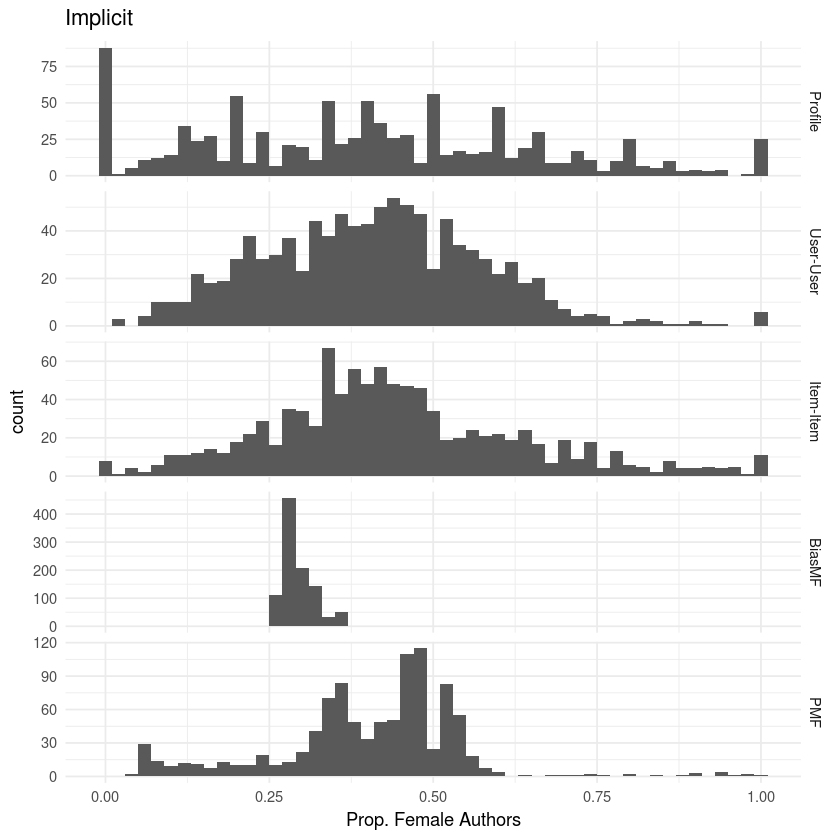

In [22]:
drawplot(file="../build/bx-implicit-hist", width=3, height=5, {
    ggplot(data=filter(user.gender_info, Algorithm != 'Popular')) +
        aes(x=PropFemale) +
        geom_histogram(binwidth=0.02) + 
        facet_grid(Algorithm ~ ., scales='free_y') +
        xlab("Prop. Female Authors") +
        ggtitle("Implicit") +
        theme_minimal()
})

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


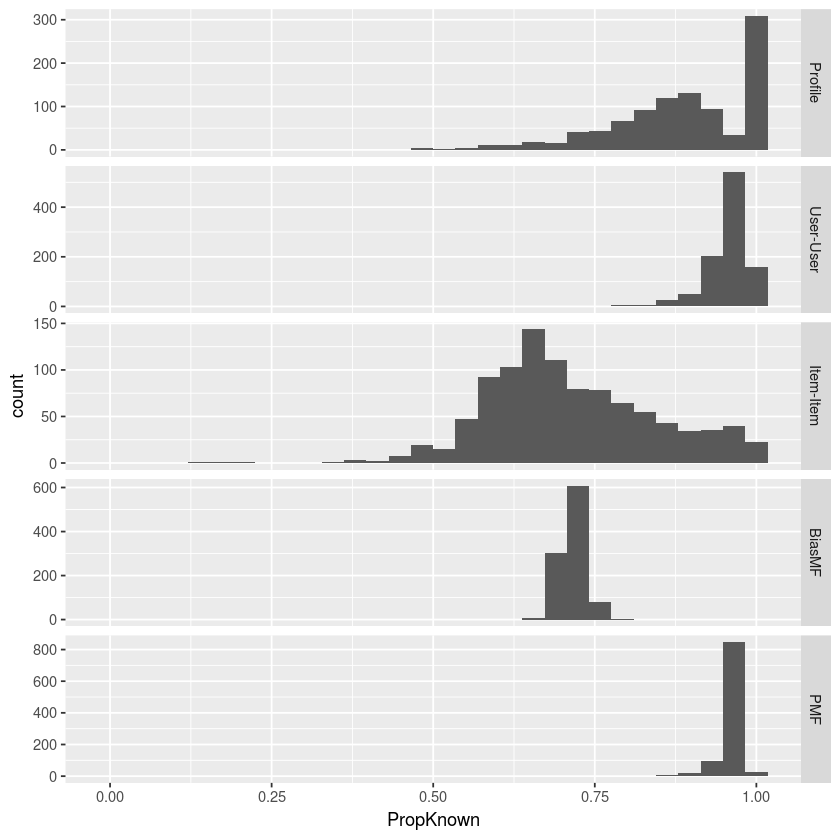

In [23]:
ggplot(data=user.gender_info, aes(x=PropKnown)) + geom_histogram() + facet_grid(Algorithm ~ ., scales='free_y')

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


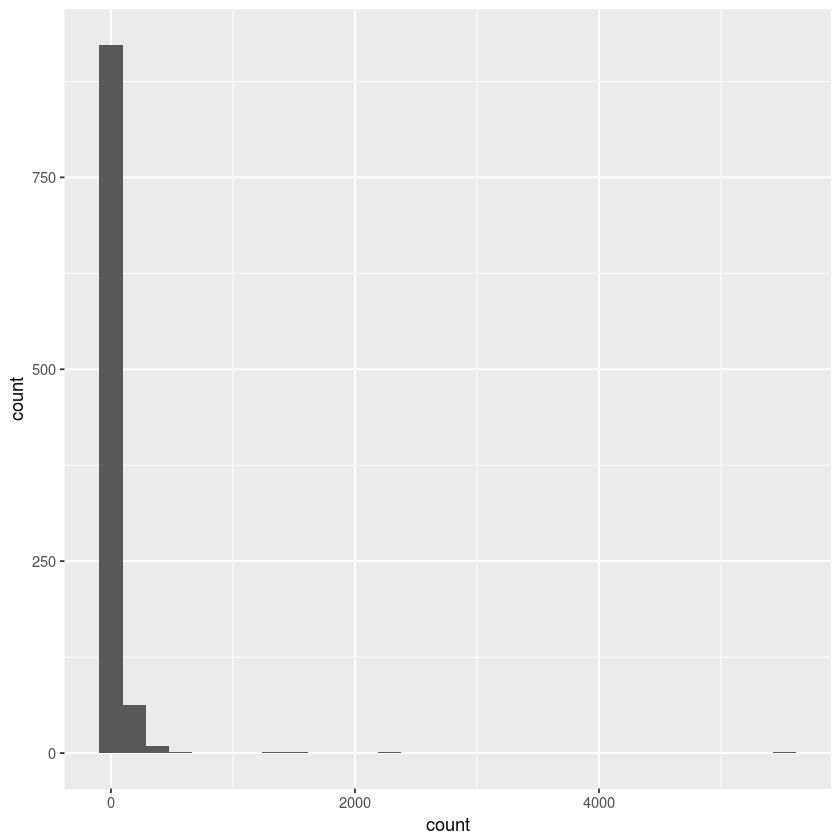

In [24]:
ggplot(data=user.rating_info, aes(x=count)) +
    geom_histogram()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


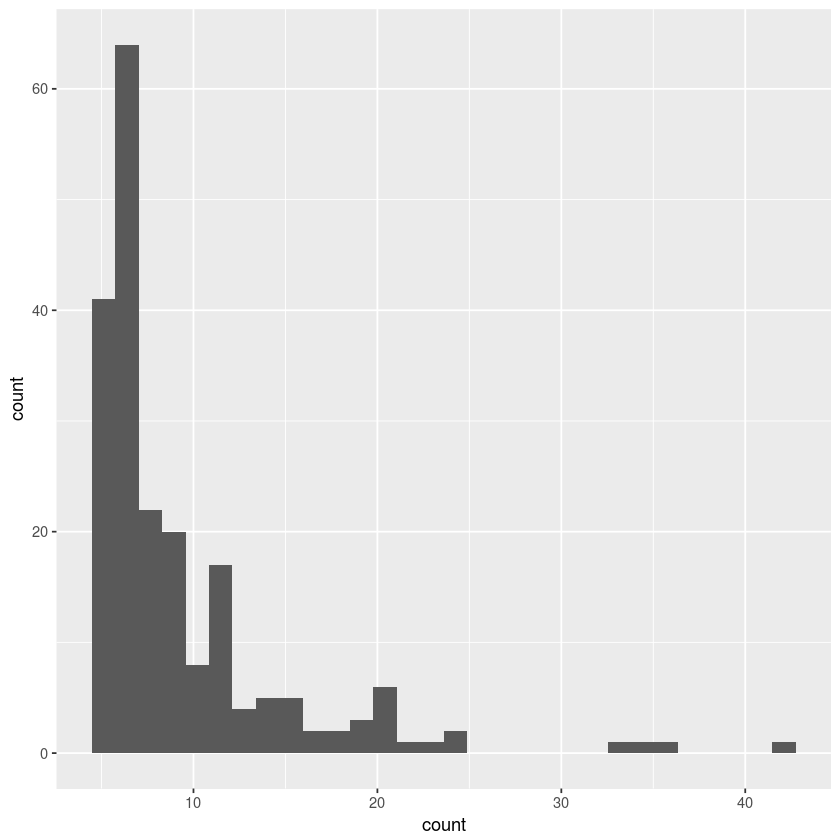

In [70]:
ggplot(data=user.rating_info %>% filter(NFemale<=1), aes(x=count)) +
    geom_histogram()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


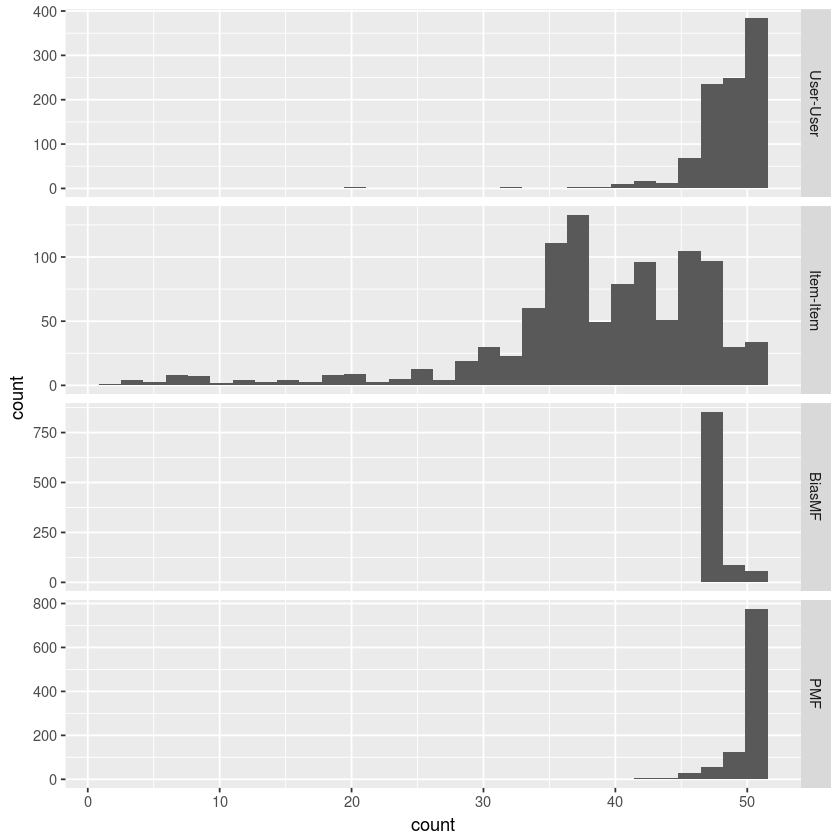

In [25]:
ggplot(data=user.gender_info %>% filter(Algorithm != 'Profile'), aes(x=count)) +
    geom_histogram() +
    facet_grid(Algorithm ~ ., scales='free_y')

In [26]:
recs %>% group_by(Algorithm, User) %>% summarize(count=n()) %>% summary()

  Algorithm              User            count    
 Length:4998        Min.   :    99   Min.   :100  
 Class :character   1st Qu.: 69687   1st Qu.:100  
 Mode  :character   Median :138886   Median :100  
                    Mean   :139027   Mean   :100  
                    3rd Qu.:207667   3rd Qu.:100  
                    Max.   :278774   Max.   :100  

In [27]:
user.gender_info %>%
    select(userID, Algorithm, PropFemale) %>%
    spread(Algorithm, PropFemale) %>%
    select(-userID) %>%
    summary()

    Profile         User-User         Item-Item          BiasMF      
 Min.   :0.0000   Min.   :0.02083   Min.   :0.0000   Min.   :0.2571  
 1st Qu.:0.2000   1st Qu.:0.28571   1st Qu.:0.3200   1st Qu.:0.2727  
 Median :0.4000   Median :0.41304   Median :0.4167   Median :0.2857  
 Mean   :0.4037   Mean   :0.41046   Mean   :0.4411   Mean   :0.2922  
 3rd Qu.:0.5983   3rd Qu.:0.52083   3rd Qu.:0.5524   3rd Qu.:0.3030  
 Max.   :1.0000   Max.   :1.00000   Max.   :1.0000   Max.   :0.3611  
                  NA's   :3         NA's   :2                        
      PMF         
 Min.   :0.04167  
 1st Qu.:0.33333  
 Median :0.42857  
 Mean   :0.40164  
 3rd Qu.:0.48980  
 Max.   :1.00000  
                  

Warning message:
“Removed 2 rows containing non-finite values (stat_boxplot).”

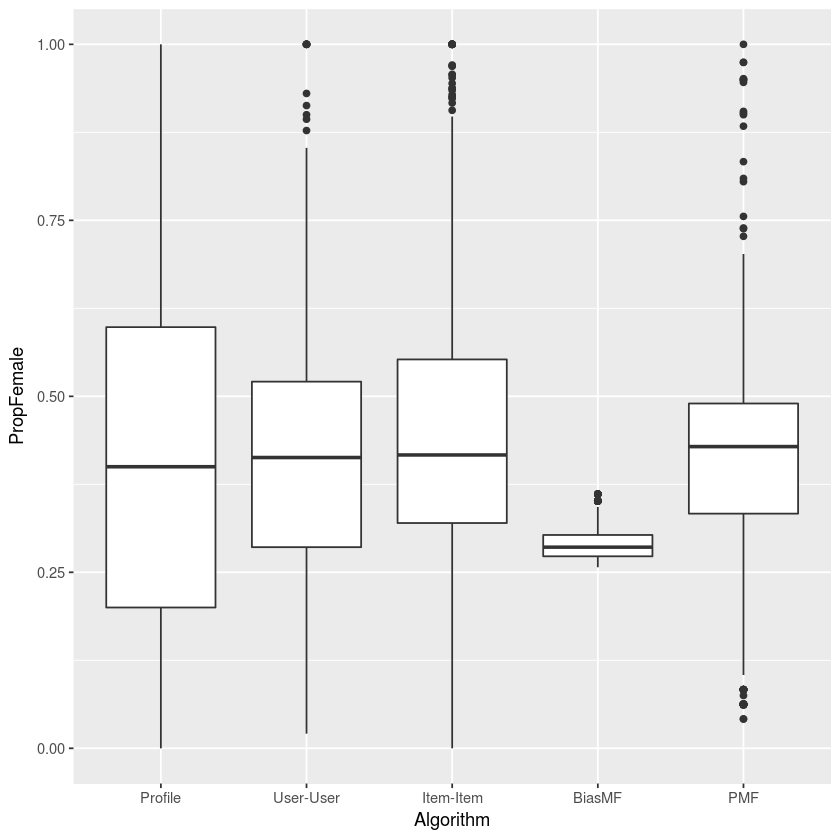

In [28]:
ggplot(user.gender_info) +
    aes(x=Algorithm, y=PropFemale) +
    geom_boxplot()

# Initial Data Summary

In [29]:
proportion_by_algorithm =  user.gender_info %>% 
                            group_by(Algorithm) %>% 
                            summarize(AvgFemaleProp = sum(NFemale) / sum(known),
                                      PropAvg = mean(PropFemale, na.rm = TRUE),
                                      PropSD = sd(PropFemale))
proportion_by_algorithm

Algorithm,AvgFemaleProp,PropAvg,PropSD
Profile,0.4673002,0.4036582,0.2543168
User-User,0.4103127,0.4104612,NaN
Item-Item,0.4529187,0.4411221,0.1951699
BiasMF,0.2926865,0.2921808,0.0243716
PMF,0.4016496,0.4016416,0.1424667


In [30]:
user.gender_info = user.gender_info %>%
    filter(known > 0) %>%
    mutate(Proportion = NFemale/known)
summary(user.gender_info)

     userID           count          ambiguous           known        
 Min.   :    99   Min.   :   2.0   Min.   : 0.0000   Min.   :   1.00  
 1st Qu.: 69690   1st Qu.:  38.0   1st Qu.: 0.0000   1st Qu.:  26.00  
 Median :138886   Median :  48.0   Median : 0.0000   Median :  35.00  
 Mean   :139015   Mean   :  45.3   Mean   : 0.5095   Mean   :  38.36  
 3rd Qu.:207667   3rd Qu.:  50.0   3rd Qu.: 1.0000   3rd Qu.:  48.00  
 Max.   :278774   Max.   :5525.0   Max.   :36.0000   Max.   :4106.00  
     NMale            NFemale          PropFemale       PropKnown     
 Min.   :   0.00   Min.   :   0.00   Min.   :0.0000   Min.   :0.1429  
 1st Qu.:  13.00   1st Qu.:   8.00   1st Qu.:0.2800   1st Qu.:0.7292  
 Median :  24.00   Median :  11.00   Median :0.3571   Median :0.9000  
 Mean   :  22.87   Mean   :  15.49   Mean   :0.3898   Mean   :0.8472  
 3rd Qu.:  27.00   3rd Qu.:  20.00   3rd Qu.:0.4898   3rd Qu.:0.9740  
 Max.   :1513.00   Max.   :2593.00   Max.   :1.0000   Max.   :1.0000  
     A

# Densities in transformed Space

In [31]:
dens.points = foreach(algo=algorithms, .combine=bind_rows, .multicombine=TRUE, .inorder=FALSE) %dopar% {
    df = user.gender_info %>% filter(Algorithm == algo)
    xydensity(x=seq(-5, 5, 0.1), y=seq(-5, 30, 0.1), 
              counts=df$NFemale,
              totals=df$known) %>%
        mutate(Algorithm=algo)
}

dens.points

x,y,alpha,beta,logPrior,logLike,rawLogPost,logJacobian,logPost,Algorithm
-5,-5.0,4.509607e-05,0.006692851,12.50,-29545.90,-29533.40,-15.01343,-29548.42,Profile
-5,-4.9,4.983887e-05,0.007396744,12.25,-29457.70,-29445.45,-14.81343,-29460.26,Profile
-5,-4.8,5.508047e-05,0.008174667,12.00,-29369.55,-29357.55,-14.61343,-29372.16,Profile
-5,-4.7,6.087333e-05,0.009034404,11.75,-29281.45,-29269.70,-14.41343,-29284.12,Profile
-5,-4.6,6.727544e-05,0.009984560,11.50,-29193.42,-29181.92,-14.21343,-29196.14,Profile
-5,-4.5,7.435086e-05,0.011034646,11.25,-29105.46,-29094.21,-14.01343,-29108.23,Profile
-5,-4.4,8.217041e-05,0.012195169,11.00,-29017.58,-29006.58,-13.81343,-29020.39,Profile
-5,-4.3,9.081234e-05,0.013477747,10.75,-28929.78,-28919.03,-13.61343,-28932.65,Profile
-5,-4.2,1.003632e-04,0.014895214,10.50,-28842.08,-28831.58,-13.41343,-28844.99,Profile
-5,-4.1,1.109184e-04,0.016461757,10.25,-28754.48,-28744.23,-13.21343,-28757.45,Profile


In [32]:
nrow(dens.points)

[1] 177255

In [33]:
summary(dens.points %>% select(logLike, logPost))

    logLike           logPost       
 Min.   :-143282   Min.   :-143302  
 1st Qu.: -59198   1st Qu.: -59208  
 Median : -36854   Median : -36866  
 Mean   : -46699   Mean   : -46708  
 3rd Qu.: -27542   3rd Qu.: -27546  
 Max.   : -17776   Max.   : -17779  

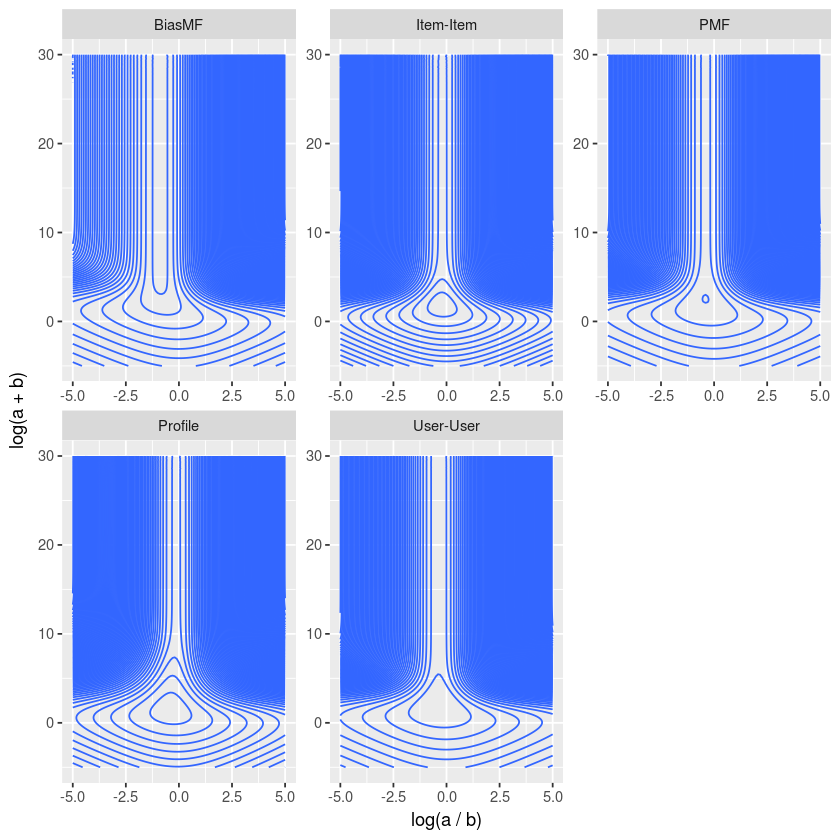

In [34]:
ggplot(dens.points) +
    aes(x=x, y=y, z=logPost) +
    geom_contour(bins=100) +
    xlab("log(a / b)") +
    ylab("log(a + b)") +
    facet_wrap(~ Algorithm, scales='free')

# Inference for Parameter Values

In [35]:
dens.points %>% group_by(Algorithm) %>%
    mutate(normPost = logPost - max(logPost)) %>%
    summarize(alpha=sum(alpha * exp(normPost)) / sum(exp(normPost)),
              beta=sum(beta * exp(normPost)) / sum(exp(normPost))) %>%
    mutate(x = log(alpha / beta),
           y = log(alpha + beta),
           mean = alpha / (alpha + beta))

Algorithm,alpha,beta,x,y,mean
BiasMF,8.850313e+11,2.176914e+12,-0.9000406,28.750072,0.2890422
Item-Item,2.996286e+00,3.660403e+00,-0.2001997,1.895622,0.4501166
PMF,5.120765e+00,7.639287e+00,-0.4000004,2.546319,0.4013122
Profile,1.818674e+00,2.703553e+00,-0.3964591,1.509005,0.4021634
User-User,3.717948e+00,5.474436e+00,-0.3869174,2.218375,0.4044596


# Integral Inference for the Posterior

In [36]:
algo.maxlp = dens.points %>% group_by(Algorithm) %>% summarize(MaxLP = max(logPost))
algo.maxlp

Algorithm,MaxLP
BiasMF,-20864.88
Item-Item,-17778.53
PMF,-31324.43
Profile,-22209.99
User-User,-29769.20


Now compute the posterior predictive distribution of $\theta$. We subtract the max log posterior (plus a bit) in order to make values finite.

In [37]:
theta.post = map_dfr(algorithms, function(algo) {
    message("integrating for algorithm ", algo)
    df = user.gender_info %>% filter(Algorithm == algo)
    maxlp = filter(algo.maxlp, Algorithm == algo)$MaxLP
    res = data_frame(Algorithm = algo,
                     Theta = seq(0.01, 0.99, 0.001)) %>%
        mutate(RawPostDens = model.theta.post(Theta, maxlp * 0.99,
                                              counts=df$NFemale, totals=df$known, max=Inf,
                                              loglike=pure_loglike)) %>%
        mutate(PostDens = RawPostDens / sum(RawPostDens * 0.001)) %>%
        mutate(CumDens = cumsum(PostDens[order(Theta)]) / sum(PostDens)) %>%
        mutate(CIMax = if_else(CumDens >= 0.025 & CumDens <= 0.975, PostDens, 0))
    message("finished algorithm ", algo)
    res
})

integrating for algorithm Profile
finished algorithm Profile
integrating for algorithm User-User
finished algorithm User-User
integrating for algorithm Item-Item
finished algorithm Item-Item
integrating for algorithm BiasMF
finished algorithm BiasMF
integrating for algorithm PMF
finished algorithm PMF


In [38]:
theta.post

Algorithm,Theta,RawPostDens,PostDens,CumDens,CIMax
Profile,0.010,1.465398e-100,0.3692811,0.0003692811,0
Profile,0.011,1.544014e-100,0.3890923,0.0007583734,0
Profile,0.012,1.619404e-100,0.4080907,0.0011664641,0
Profile,0.013,1.691937e-100,0.4263690,0.0015928331,0
Profile,0.014,1.761913e-100,0.4440030,0.0020368361,0
Profile,0.015,1.829581e-100,0.4610554,0.0024978915,0
Profile,0.016,1.895150e-100,0.4775788,0.0029754704,0
Profile,0.017,1.958797e-100,0.4936180,0.0034690884,0
Profile,0.018,2.020675e-100,0.5092114,0.0039782998,0
Profile,0.019,2.080916e-100,0.5243921,0.0045026919,0


In [39]:
post_sum = theta.post %>%
    group_by(Algorithm) %>%
    summarize(mean = sum(Theta * PostDens) / sum(PostDens),
              cimin=Theta[which(CumDens >= 0.025)[1]],
              cimax=Theta[which(CumDens > 0.975)[1]]) %>%
    ungroup() %>%
    inner_join(rename(proportion_by_algorithm, RawMean=AvgFemaleProp))
post_sum

Joining, by = "Algorithm"
Warning message:
“Column `Algorithm` joining character vector and factor, coercing into character vector”

Algorithm,mean,cimin,cimax,RawMean,PropAvg,PropSD
BiasMF,0.2693084,0.190,0.357,0.2926865,0.2921808,0.0243716
Item-Item,0.4257287,0.117,0.775,0.4529187,0.4411221,0.1951699
PMF,0.3981805,0.171,0.652,0.4016496,0.4016416,0.1424667
Profile,0.3941400,0.048,0.837,0.4673002,0.4036582,0.2543168
User-User,0.4139636,0.144,0.717,0.4103127,0.4104612,NaN


In [40]:
means = post_sum %>%
    select(Algorithm, Posterior=mean, Raw=RawMean) %>%
    melt(id.vars = "Algorithm") %>%
    rename(Mean=variable)
means

Algorithm,Mean,value
BiasMF,Posterior,0.2693084
Item-Item,Posterior,0.4257287
PMF,Posterior,0.3981805
Profile,Posterior,0.3941400
User-User,Posterior,0.4139636
BiasMF,Raw,0.2926865
Item-Item,Raw,0.4529187
PMF,Raw,0.4016496
Profile,Raw,0.4673002
User-User,Raw,0.4103127


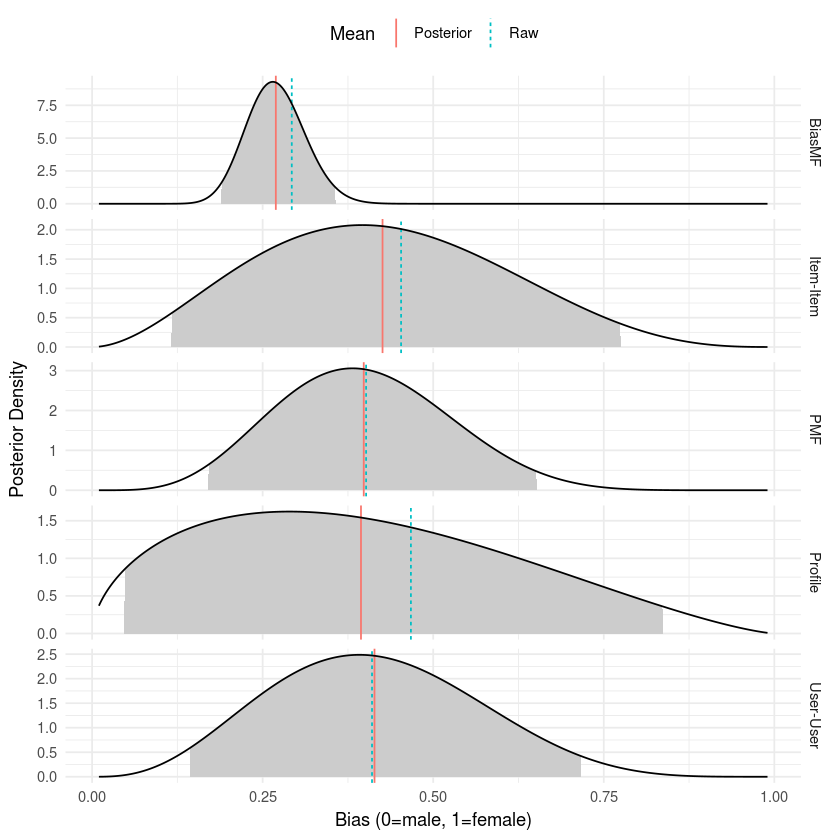

In [41]:
drawplot(file="../build/bx-implicit-posteriors", width=5, height=6, {
    ggplot(theta.post) +
        aes(x=Theta, y=PostDens) +
        geom_area(mapping=aes(y=CIMax), fill="gray80") +
        geom_vline(data=means, aes(xintercept=value, color=Mean, linetype=Mean)) +
        geom_line() +
        facet_grid(Algorithm ~ ., scales='free_y') +
        xlab("Bias (0=male, 1=female)") +
        ylab("Posterior Density") +
        theme_minimal() +
        theme(legend.position="top")
})

## Scatterplots

In [42]:
joined.info = user.rec_info %>%
    dcast(userID ~ Algorithm, value.var=c("PropFemale")) %>%
    select(userID, 
           `User-User`=`UserUser-Implicit`,
           `Item-Item`=`ItemItem-Implicit`,
           MF=`FunkSVD-Implicit`,
           PF=`PF-Implicit`) %>%
    inner_join(user.rating_info %>% select(userID, Input=PropFemale)) %>%
    melt(id.vars = c("userID", "Input"), variable.name = "Algorithm", value.name = "Output")
joined.info

Joining, by = "userID"


userID,Input,Algorithm,Output
99,0.10000000,User-User,0.36170213
476,0.33333333,User-User,0.51111111
566,0.33333333,User-User,0.45833333
728,0.13333333,User-User,0.08333333
843,0.60000000,User-User,0.53061224
914,0.08333333,User-User,0.42500000
1083,0.33333333,User-User,0.45833333
1688,0.40000000,User-User,0.56818182
1990,0.00000000,User-User,NaN
2977,0.43209877,User-User,0.46938776


`geom_smooth()` using method = 'gam'
Warning message:
“Removed 5 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 5 rows containing missing values (geom_point).”`geom_smooth()` using method = 'gam'
Warning message:
“Removed 5 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 5 rows containing missing values (geom_point).”`geom_smooth()` using method = 'gam'
Warning message:
“Removed 5 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 5 rows containing missing values (geom_point).”

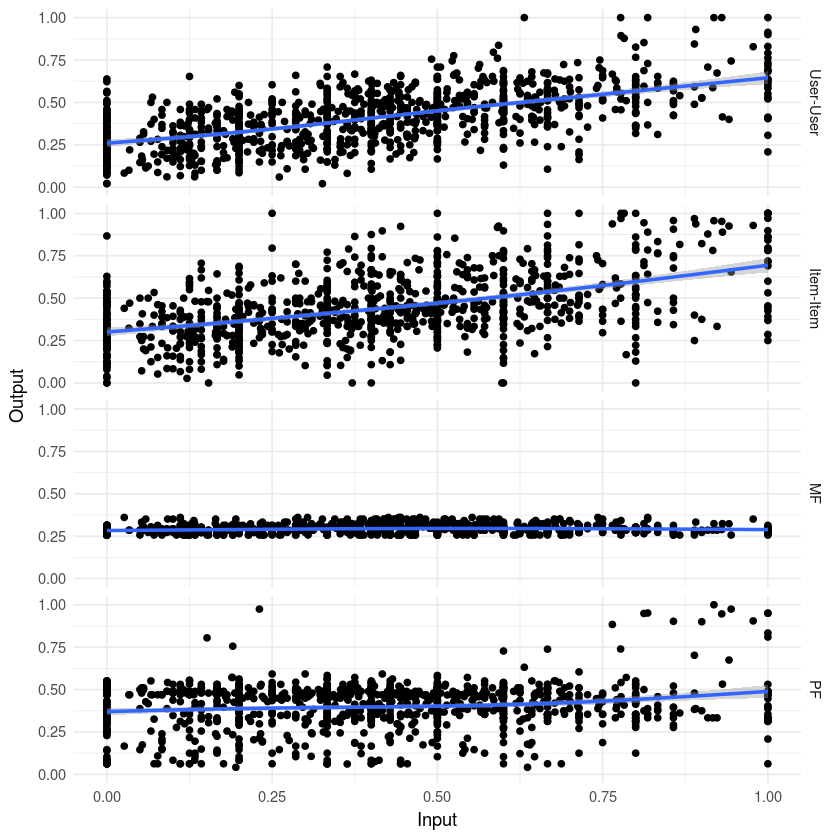

In [43]:
drawplot(file="../build/implicit-scatter", width=5, height=5, {
    ggplot(joined.info) +
        aes(x=Input, y=Output) +
        geom_point() +
        geom_smooth() +
        facet_grid(Algorithm ~ .) +
        theme_minimal()
})

In [44]:
joined.info %>%
    group_by(Algorithm) %>%
    summarize(Cor=cor(Input, Output, use="pairwise.complete.obs")) %>%
    mutate(R2=Cor*Cor)

Algorithm,Cor,R2
User-User,0.6008217,0.36098672
Item-Item,0.5008722,0.25087293
MF,0.1113429,0.01239724
PF,0.1610074,0.02592339


In [45]:
summary(lm(Output ~ Input, data=joined.info, subset=Algorithm == 'User-User'))


Call:
lm(formula = Output ~ Input, data = joined.info, subset = Algorithm == 
    "User-User")

Residuals:
     Min       1Q   Median       3Q      Max 
-0.43870 -0.09270  0.00077  0.08457  0.49936 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.249739   0.008004   31.20   <2e-16 ***
Input       0.397298   0.016758   23.71   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1344 on 995 degrees of freedom
  (3 observations deleted due to missingness)
Multiple R-squared:  0.361,	Adjusted R-squared:  0.3603 
F-statistic: 562.1 on 1 and 995 DF,  p-value: < 2.2e-16


In [46]:
summary(lm(Output ~ Input, data=joined.info, subset=Algorithm == 'Item-Item'))


Call:
lm(formula = Output ~ Input, data = joined.info, subset = Algorithm == 
    "Item-Item")

Residuals:
     Min       1Q   Median       3Q      Max 
-0.59335 -0.10478 -0.01611  0.10178  0.61811 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.28577    0.01005   28.44   <2e-16 ***
Input        0.38448    0.02105   18.26   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.169 on 996 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.2509,	Adjusted R-squared:  0.2501 
F-statistic: 333.5 on 1 and 996 DF,  p-value: < 2.2e-16


In [47]:
summary(lm(Output ~ Input, data=joined.info, subset=Algorithm == 'MF'))


Call:
lm(formula = Output ~ Input, data = joined.info, subset = Algorithm == 
    "MF")

Residuals:
      Min        1Q    Median        3Q       Max 
-0.041401 -0.017518 -0.004748  0.014048  0.072957 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.287874   0.001438 200.183  < 2e-16 ***
Input       0.010670   0.003015   3.539 0.000419 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.02423 on 998 degrees of freedom
Multiple R-squared:  0.0124,	Adjusted R-squared:  0.01141 
F-statistic: 12.53 on 1 and 998 DF,  p-value: 0.0004194


In [48]:
summary(lm(Output ~ Input, data=joined.info, subset=Algorithm == 'PF'))


Call:
lm(formula = Output ~ Input, data = joined.info, subset = Algorithm == 
    "PF")

Residuals:
     Min       1Q   Median       3Q      Max 
-0.39293 -0.07125  0.02106  0.09288  0.58831 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.365233   0.008349  43.748  < 2e-16 ***
Input       0.090195   0.017501   5.154 3.08e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1407 on 998 degrees of freedom
Multiple R-squared:  0.02592,	Adjusted R-squared:  0.02495 
F-statistic: 26.56 on 1 and 998 DF,  p-value: 3.079e-07


## MCMC Analysis

Now we will use STAN to infer the data using MCMC.

In [49]:
raw_dframe = map_dfr(algorithms, function(algo) {
    df = user.gender_info %>% filter(Algorithm == algo)
    density_frame(df$PropFemale, from=0, to=1) %>%
        mutate(Algorithm = algo) %>%
        select(Algorithm, GenderBias=value, Density=density)
})
raw_dframe

Algorithm,GenderBias,Density
Profile,0.000000000,0.7830315
Profile,0.001956947,0.7911301
Profile,0.003913894,0.7987562
Profile,0.005870841,0.8058778
Profile,0.007827789,0.8126641
Profile,0.009784736,0.8190450
Profile,0.011741683,0.8249023
Profile,0.013698630,0.8304497
Profile,0.015655577,0.8356683
Profile,0.017612524,0.8403715


### Profile Model

We will start by just inferring user profile statistics independently.

In [50]:
indep_model

S4 class stanmodel 'independent' coded as follows:
data {
    int<lower=0> J;
    int<lower=0> n[J];
    int<lower=0> y[J];
}
parameters {
    real<lower=0,upper=1> phi;
    real<lower=0.1> lambda;
    real<lower=0,upper=1> theta[J];
}
transformed parameters {
    real<lower=0> alpha;
    real<lower=0> beta;
    alpha = lambda * phi;
    beta = lambda * (1 - phi);
}
model {
    phi ~ beta(1,1);
    lambda ~ pareto(0.1, 1.5);
    theta ~ beta(alpha, beta);
    y ~ binomial(n, theta);
}
generated quantities {
    real thetaP;
    thetaP = beta_rng(alpha, beta);
} 

In [51]:
profile_fit = sampling(indep_model,
                       data=list(J=nrow(user.rating_info),
                                 n=user.rating_info$known,
                                 y=user.rating_info$NFemale),
                       chains=8, iter=4000)

In [52]:
print(profile_fit, pars=c("phi", "lambda", "alpha", "beta", "thetaP"))

Inference for Stan model: independent.
8 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=16000.

       mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
phi    0.41       0 0.01 0.39 0.40 0.41 0.41  0.42 13831    1
lambda 4.49       0 0.28 3.96 4.30 4.48 4.68  5.07  5432    1
alpha  1.82       0 0.12 1.60 1.74 1.82 1.90  2.06  5574    1
beta   2.67       0 0.17 2.35 2.55 2.67 2.79  3.03  5655    1
thetaP 0.41       0 0.21 0.06 0.24 0.39 0.56  0.83 16000    1

Samples were drawn using NUTS(diag_e) at Thu Dec  7 21:01:54 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [53]:
profile_sim = rstan::extract(profile_fit, permuted=TRUE)

In [54]:
uthetas = colMeans(profile_sim$theta)
uth_dens = density(uthetas, from=0, to=1)
utheta_df = data_frame(Theta=uth_dens$x, PostDens=uth_dens$y)

In [65]:
ln_profile_fit = stan(file="logitnormal.stan",
                          data=list(J=nrow(user.rating_info),
                                    c=user.rating_info$count,
                                    n=user.rating_info$known,
                                    y=user.rating_info$NFemale),
                          chains=4, iter=2000, cores=1)

hash mismatch so recompiling; make sure Stan code ends with a blank line


In file included from /home/MICHAELEKSTRAND/miniconda2/envs/bias/lib/R/library/rstan/include/rstan/rstaninc.hpp:3:0,
                 from file4525617938f2.cpp:624:
/home/MICHAELEKSTRAND/miniconda2/envs/bias/lib/R/library/rstan/include/rstan/stan_fit.hpp: In function 'int rstan::{anonymous}::command(rstan::stan_args&, Model&, Rcpp::List&, const std::vector<long unsigned int>&, const std::vector<std::__cxx11::basic_string<char> >&, RNG_t&)':
/home/MICHAELEKSTRAND/miniconda2/envs/bias/lib/R/library/rstan/include/rstan/stan_fit.hpp:438:8: warning: 'template<class> class std::auto_ptr' is deprecated [-Wdeprecated-declarations]
   std::auto_ptr<stan::io::var_context> init_context_ptr;
        ^~~~~~~~
In file included from /home/MICHAELEKSTRAND/miniconda2/envs/bias/x86_64-conda_cos6-linux-gnu/include/c++/7.2.0/bits/locale_conv.h:41:0,
                 from /home/MICHAELEKSTRAND/miniconda2/envs/bias/x86_64-conda_cos6-linux-gnu/include/c++/7.2.0/locale:43,
                 from /home/MICHAELE

In [66]:
print(ln_profile_fit, pars=c("mu", "sig2", "rate", "thetaP", "nP", "yP"))

Inference for Stan model: logitnormal.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean    sd  2.5%   25%   50%   75% 97.5% n_eff Rhat
mu     -0.47    0.00  0.04 -0.55 -0.50 -0.47 -0.44 -0.39  3232 1.00
sig2    1.06    0.00  0.04  0.99  1.03  1.06  1.08  1.13  1348 1.01
rate   42.10    0.00  0.20 41.70 41.96 42.10 42.23 42.51  4000 1.00
thetaP  0.40    0.00  0.21  0.07  0.23  0.38  0.55  0.84  4000 1.00
nP     46.85    0.10  6.44 35.00 43.00 47.00 51.00 60.00  4000 1.00
yP     18.86    0.17 10.78  2.00 10.00 17.00 26.00 42.00  4000 1.00

Samples were drawn using NUTS(diag_e) at Thu Dec  7 21:18:54 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [67]:
ln_profile_sim = rstan::extract(ln_profile_fit, permuted=TRUE)

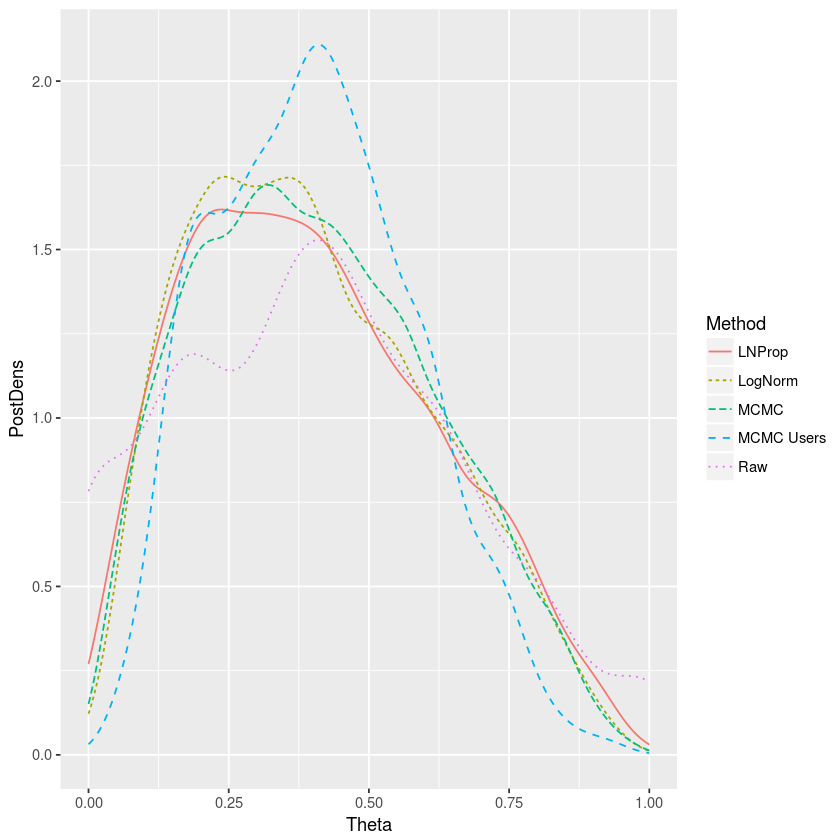

In [68]:
pf_theta_dframe = 
    bind_rows(MCMC=select(density_frame(profile_sim$thetaP, from=0, to=1),
                          Theta=value, PostDens=density),
              # Integrated=select(theta.post %>% filter(Algorithm=='Profile'), Theta, PostDens),
              `MCMC Users`=utheta_df,
              LogNorm=select(density_frame(ln_profile_sim$thetaP, from=0, to=1),
                             Theta=value, PostDens=density),
              LNProp=select(density_frame(ln_profile_sim$yP / ln_profile_sim$nP, from=0, to=1),
                            Theta=value, PostDens=density),
              Raw=select(filter(raw_dframe, Algorithm == 'Profile'), 
                         Theta=GenderBias, PostDens=Density),
              .id="Method")
ggplot(pf_theta_dframe) +
    aes(x=Theta, y=PostDens, linetype=Method, color=Method) +
    geom_line()

### All Algorithms Fitting

In [97]:
indep_fits = map(algorithms, function(algo) {
    message("fitting model for ", algo)
    df = user.gender_info %>% filter(Algorithm == algo)
    sampling(indep_model,
             data=list(J=nrow(df),
                       n=df$known,
                       y=df$NFemale),
             chains=8, iter=3000, thin=2, control=list(adapt_delta=0.9))
})

fitting model for Profile
Warning message:
“There were 245 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”fitting model for User-User


In [ ]:
names(indep_fits) = algorithms

In [ ]:
indep_sims = map(indep_fits, function(fit) {
    rstan::extract(fit, permuted=TRUE)
})
indep_dens = map(indep_sims, function(sim) {
    density(sim$thetaP, from=0, to=1)
})

In [ ]:
indep_theta_df = map_dfr(indep_dens, function(dens) {
    data_frame(GenderBias=dens$x, Density=pf_theta_dens$y)
}, .id="Algorithm")
indep_theta_df

In [ ]:
integrated_dframe = 
    bind_rows(MCMC=indep_theta_df,
              Integrated=select(theta.post, Algorithm, GenderBias=Theta, Density=PostDens),
              Raw=raw_dframe,
              .id="Method")
ggplot(integrated_dframe) +
    aes(x=GenderBias, y=Density, linetype=Method, color=Method) +
    geom_line() +
    facet_grid(Algorithm ~ ., scales="free_y")

### Integrated Model

Now, we will fit a single integrated model that captures recommender relationships between inputs and outputs.

In [58]:
full_model

S4 class stanmodel 'withrecs' coded as follows:
data {
    // The number of algorithms
    int<lower=0> A;
    // The number of data points
    int<lower=0> J;
    // The number of user,rec pairs
    int<lower=0> NL;
    // The user profile sizes
    int<lower=0> n[J];
    // The user profile female author counts
    int<lower=0> y[J];
    // The user rec list users
    int<lower=0> ru[NL];
    // The user rec list algorithms
    int<lower=0> ra[NL];
    // The user rec list sizes
    int<lower=0> rn[NL];
    // The user rec list female author counts
    int<lower=0> ry[NL];
}
parameters {
    // user profile distribution parameters
    real<lower=0,upper=1> phi;
    real<lower=0.1> lambda;
    // recommender intercepts
    vector[A] recB;
    // recommender slopes
    vector[A] recS;
    // user profile biases (ignored)
    real<lower=0,upper=1> theta[J];
}
transformed parameters {
    // user profile distribution parameters
    real<lower=0> alpha;
    real<lower=0> beta;

    // rec

We need to prepare data. In addition to profile parameters, it takes the algorithm data.

In [72]:
user_data = user.rating_info %>%
    select(userID, known, NFemale) %>%
    arrange(userID) %>%
    mutate(userNum = 1:n())
user_data

userID,known,NFemale,userNum
99,10,1,1
476,6,2,2
566,6,2,3
728,15,2,4
843,10,6,5
914,12,1,6
1083,6,2,7
1688,5,2,8
1990,5,0,9
2977,162,70,10


In [73]:
rec_data = user.gender_info %>%
    filter(Algorithm != "Profile") %>%
    select(userID, Algorithm, known, NFemale) %>%
    mutate(Algorithm = as.factor(as.character(Algorithm))) %>%
    inner_join(select(user_data, userID, userNum))
rec_data

Joining, by = "userID"


userID,Algorithm,known,NFemale,userNum
99,BiasMF,34,10,1
99,Item-Item,29,9,1
99,PMF,48,21,1
99,User-User,47,17,1
476,BiasMF,34,10,2
476,Item-Item,38,23,2
476,PMF,48,15,2
476,User-User,45,23,2
566,BiasMF,33,9,3
566,Item-Item,22,1,3


In [74]:
summary(rec_data)

     userID           Algorithm        known          NFemale    
 Min.   :    99   BiasMF   :1000   Min.   : 1.00   Min.   : 0.0  
 1st Qu.: 69690   Item-Item: 998   1st Qu.:33.00   1st Qu.: 9.0  
 Median :138886   PMF      :1000   Median :41.00   Median :13.0  
 Mean   :139002   User-User: 997   Mean   :39.06   Mean   :15.2  
 3rd Qu.:207667                    3rd Qu.:48.00   3rd Qu.:21.0  
 Max.   :278774                    Max.   :50.00   Max.   :47.0  
    userNum      
 Min.   :   1.0  
 1st Qu.: 250.5  
 Median : 500.0  
 Mean   : 500.3  
 3rd Qu.: 750.0  
 Max.   :1000.0  

In [75]:
rec_algos = levels(rec_data$Algorithm)
rec_algos

[1] "BiasMF"    "Item-Item" "PMF"       "User-User"

And we fit the model!

In [77]:
full_fit = stan(file="withrecs.stan",
                    data=list(J=nrow(user_data), 
                              A=length(rec_algos),
                              NL=nrow(rec_data),
                              n=user_data$known,
                              y=user_data$NFemale,
                              ru=rec_data$userNum,
                              ra=as.integer(rec_data$Algorithm),
                              rn=rec_data$known,
                              ry=rec_data$NFemale))

hash mismatch so recompiling; make sure Stan code ends with a blank line


In file included from /home/MICHAELEKSTRAND/miniconda2/envs/bias/lib/R/library/rstan/include/rstan/rstaninc.hpp:3:0,
                 from file452552a196af.cpp:856:
/home/MICHAELEKSTRAND/miniconda2/envs/bias/lib/R/library/rstan/include/rstan/stan_fit.hpp: In function 'int rstan::{anonymous}::command(rstan::stan_args&, Model&, Rcpp::List&, const std::vector<long unsigned int>&, const std::vector<std::__cxx11::basic_string<char> >&, RNG_t&)':
/home/MICHAELEKSTRAND/miniconda2/envs/bias/lib/R/library/rstan/include/rstan/stan_fit.hpp:438:8: warning: 'template<class> class std::auto_ptr' is deprecated [-Wdeprecated-declarations]
   std::auto_ptr<stan::io::var_context> init_context_ptr;
        ^~~~~~~~
In file included from /home/MICHAELEKSTRAND/miniconda2/envs/bias/x86_64-conda_cos6-linux-gnu/include/c++/7.2.0/bits/locale_conv.h:41:0,
                 from /home/MICHAELEKSTRAND/miniconda2/envs/bias/x86_64-conda_cos6-linux-gnu/include/c++/7.2.0/locale:43,
                 from /home/MICHAELE

In [80]:
print(full_fit, pars=c("phi", "lambda", "alpha", "beta", "thetaP", "recB", "recS", "thetaRP"))

Inference for Stan model: withrecs.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean   sd  2.5%   25%   50%   75% 97.5% n_eff Rhat
phi         0.41    0.00 0.01  0.39  0.40  0.41  0.41  0.42  1946    1
lambda      5.89    0.01 0.35  5.26  5.66  5.88  6.12  6.61   840    1
alpha       2.39    0.00 0.14  2.12  2.29  2.39  2.49  2.69   911    1
beta        3.50    0.01 0.21  3.11  3.36  3.49  3.64  3.95   838    1
thetaP      0.41    0.00 0.19  0.09  0.27  0.40  0.53  0.78  4000    1
recB[1]    -0.87    0.00 0.01 -0.90 -0.88 -0.87 -0.86 -0.85  4000    1
recB[2]     0.13    0.00 0.02  0.09  0.11  0.12  0.14  0.17  1103    1
recB[3]    -0.29    0.00 0.01 -0.32 -0.30 -0.29 -0.29 -0.27  2376    1
recB[4]    -0.07    0.00 0.02 -0.11 -0.08 -0.07 -0.06 -0.04   912    1
recS[1]     0.02    0.00 0.01 -0.01  0.01  0.02  0.03  0.04  4000    1
recS[2]     0.78    0.00 0.03  0.72  0.76  0.77  0.79  0.83   811

In [81]:
full_sim = rstan::extract(full_fit, permuted=TRUE)

What are the intervals on our algorithm intercepts?

In [82]:
map_df(1:length(rec_algos), function(ri) {
    data_frame(Algorithm=rec_algos[ri],
               Intercept=mean(full_sim$recB[,ri]),
               IntLow=quantile(full_sim$recB[,ri], 0.025),
               IntHigh=quantile(full_sim$recB[,ri], 0.975),
               Slope=mean(full_sim$recS[,ri]),
               SlopeLow=quantile(full_sim$recS[,ri], 0.025),
               SlopeHigh=quantile(full_sim$recS[,ri], 0.975))
})

Algorithm,Intercept,IntLow,IntHigh,Slope,SlopeLow,SlopeHigh
BiasMF,-0.87388187,-0.90042817,-0.84771115,0.0190024,-0.005804378,0.04399916
Item-Item,0.12519840,0.08657868,0.16503581,0.7750786,0.724862323,0.82709597
PMF,-0.29414251,-0.31643471,-0.27072444,0.2362163,0.208071650,0.26578157
User-User,-0.07165445,-0.10569558,-0.03713453,0.6976248,0.654398820,0.74446605


In [83]:
rec_thetas = full_sim$thetaRP
colnames(rec_thetas) = rec_algos
rec_thetas = as_data_frame(rec_thetas)
inf_thetas = map_dfr(algorithms, function(algo) {
    if (algo == "Profile") {
        theta = full_sim$thetaP
    } else {
        theta = rec_thetas[[algo]]
    }
    density_frame(theta, from=0, to=1) %>%
        mutate(Algorithm=algo) %>%
        select(Algorithm, GenderBias=value, Density=density)
})
inf_thetas

Algorithm,GenderBias,Density
Profile,0.000000000,0.06102755
Profile,0.001956947,0.06631139
Profile,0.003913894,0.07188544
Profile,0.005870841,0.07775416
Profile,0.007827789,0.08393827
Profile,0.009784736,0.09051342
Profile,0.011741683,0.09739621
Profile,0.013698630,0.10458843
Profile,0.015655577,0.11209149
Profile,0.017612524,0.11993044


In [84]:
pred_ys = full_sim$yRP
colnames(pred_ys) = rec_algos
pred_ys = as_data_frame(pred_ys)

inf_props = map_dfr(algorithms, function(algo) {
    if (algo == "Profile") {
        n = full_sim$nP
        y = full_sim$yP
    } else {
        n = 50
        y = pred_ys[[algo]]
    }
    density_frame(y / n, from=0, to=1) %>%
        mutate(Algorithm=algo) %>%
        select(Algorithm, GenderBias=value, Density=density)
})
inf_props

Algorithm,GenderBias,Density
Profile,0.000000000,0.1767423
Profile,0.001956947,0.1857647
Profile,0.003913894,0.1950458
Profile,0.005870841,0.2045508
Profile,0.007827789,0.2142782
Profile,0.009784736,0.2242269
Profile,0.011741683,0.2344737
Profile,0.013698630,0.2449376
Profile,0.015655577,0.2556125
Profile,0.017612524,0.2664950


In [91]:
all_thetas = bind_rows(`Indep Analytic`=select(theta.post, Algorithm, GenderBias=Theta, Density=PostDens),
                       `Full MCMC`=inf_thetas,
                       `Full MCMC Y`=inf_props,
                       Raw=raw_dframe,
                       .id="Method")
all_thetas

Method,Algorithm,GenderBias,Density
Indep Analytic,Profile,0.010,0.3692811
Indep Analytic,Profile,0.011,0.3890923
Indep Analytic,Profile,0.012,0.4080907
Indep Analytic,Profile,0.013,0.4263690
Indep Analytic,Profile,0.014,0.4440030
Indep Analytic,Profile,0.015,0.4610554
Indep Analytic,Profile,0.016,0.4775788
Indep Analytic,Profile,0.017,0.4936180
Indep Analytic,Profile,0.018,0.5092114
Indep Analytic,Profile,0.019,0.5243921


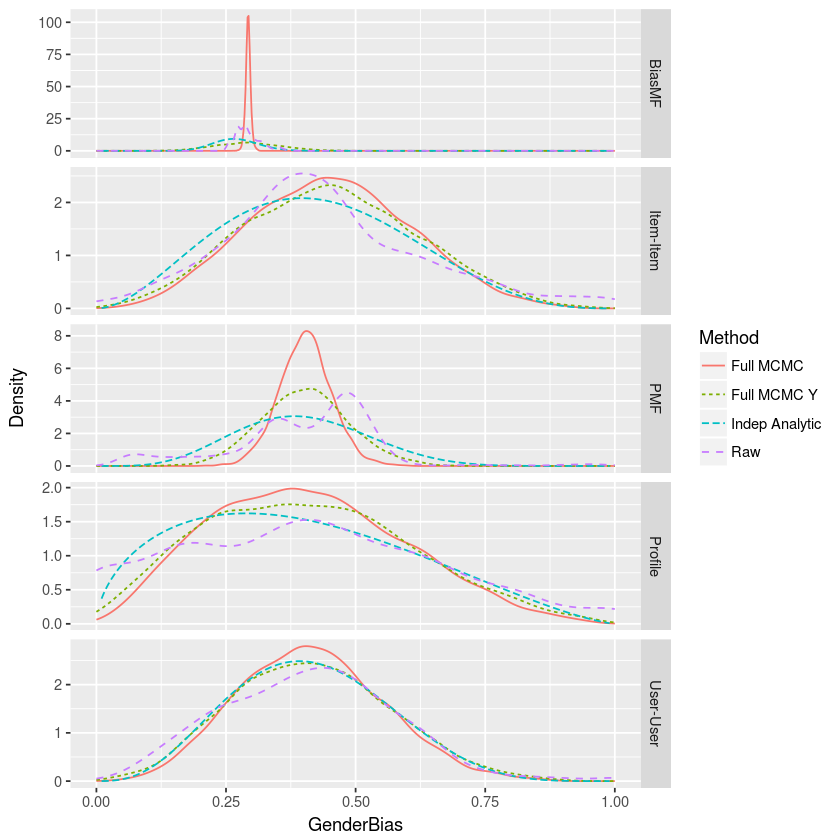

In [92]:
ggplot(all_thetas) +
    aes(x=GenderBias, y=Density, linetype=Method, color=Method) +
    geom_line() +
    facet_grid(Algorithm ~ ., scales="free_y")